# import libraries

In [1]:
#import libraries
from matplotlib import cm as colormap
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import numpy as np
import pandas as pd
#!pip install uproot awkward
#!pip install lightgbm
import uproot#<module 'uproot' from '/usr/local/lib/python3.6/site-packages/uproot/__init__.py'>
import seaborn as sns
import lightgbm as lgb

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from scipy.stats.contingency import crosstab

In [2]:
!python --version
#!pip install -U kaleido

Python 2.7.5


In [16]:
!mount --bind /afs/cern.ch/user/c/chenz ~/test_mount

mount: only root can use "--bind" option


In [15]:
!ls ~/

bin				   macro	      private
cms				   Mail		      public
default.sh			   multifiledir.txt   seaborn-data
Desktop				   multifiledir.txt~  ssl
Documents			   myrepo	      test
dR_gentau_jet_vs_gentau_pt_2D.pdf  nfs		      test_mount
fig.pdf				   ns_imap	      Untitled.ipynb
HTCondor_test			   nsmail	      virtualmachine
KDesktop			   ppt		      www


# load file

In [7]:
# import root file
path0='/afs/desy.de/user/c/chenze/nfs/TauReco/example_rootfiles/DYJetsToLL_M-50.root'
path1='/afs/cern.ch/user/c/chenz/CMSSW_10_6_20/src/MyCode/TupleProducer/test/output/eventTuple_80__dataforML_flattend2_dR02_jetpt_jet.root'
data_file = uproot.open(path1)

PermissionError: [Errno 13] Permission denied: '/afs/cern.ch/user/c/chenz/CMSSW_10_6_20/src/MyCode/TupleProducer/test/output/eventTuple_80__dataforML_flattend2_dR02_jetpt_jet.root'

In [4]:
#take out Ttree|
data_tree = data_file['ML_data']

In [5]:
#get branches
branches = data_tree.keys()
#branches = [branch.decode("utf-8").split(';')[0] for branch in branches]
print(len(branches))
branches

53


['dm_gen',
 'dm_HPS',
 'dR_weighted_by_ptratio',
 'n_photons',
 'pt_ratio_Lphoton',
 'pt_ratio_NLphoton',
 'pt_ratio_NNLphoton',
 'pt_ratio_NNNLphoton',
 'deltaEta_Lphoton',
 'deltaEta_NLphoton',
 'deltaEta_NNLphoton',
 'deltaEta_NNNLphoton',
 'deltaPhi_Lphoton',
 'deltaPhi_NLphoton',
 'deltaPhi_NNLphoton',
 'deltaPhi_NNNLphoton',
 'n_chargedHadrons',
 'pt_ratio_LchargedHadron',
 'pt_ratio_NLchargedHadron',
 'pt_ratio_NNLchargedHadron',
 'deltaEta_LchargedHadron',
 'deltaEta_NLchargedHadron',
 'deltaEta_NNLchargedHadron',
 'deltaPhi_LchargedHadron',
 'deltaPhi_NLchargedHadron',
 'deltaPhi_NNLchargedHadron',
 'n_neutralHadrons',
 'pt_ratio_LneutralHadron',
 'pt_ratio_NLneutralHadron',
 'deltaEta_LneutralHadron',
 'deltaEta_NLneutralHadron',
 'deltaPhi_LneutralHadron',
 'deltaPhi_NLneutralHadron',
 'n_electrons',
 'pt_ratio_Lelectron',
 'pt_ratio_NLelectron',
 'pt_ratio_NNLelectron',
 'pt_ratio_NNNLelectron',
 'deltaEta_Lelectron',
 'deltaEta_NLelectron',
 'deltaEta_NNLelectron',
 'delta

In [6]:
#transform .uproot to .nparray
data=data_tree.arrays(library='pandas')
#data = data_tree.pandas.df()

In [7]:
#get X_feature and y for ML
bran=branches.copy()
bran.remove('dm_gen')
if(bran.count('dm_HPS')):
    bran.remove('dm_HPS')
    dm_HPS=data['dm_HPS']
if(1):
    bran=[name for name in bran if name.find('deltaR_')==-1 ]
else:
    bran=[name for name in bran if (name.find('deltaEta_')==-1 and name.find('deltaPhi_')==-1 )]
#bran.remove('n_photons_signal')
#bran.remove('emFraction')
#bran.remove('dR_weighted_by_ptratio')
#bran=[name for name in branches if name.find('electron')==-1]#name.find('muon') == -1 and 
#bran.remove('n_hadrons_n')
#bran.remove('dm_gen')

X=data[bran]
y=data['dm_gen']

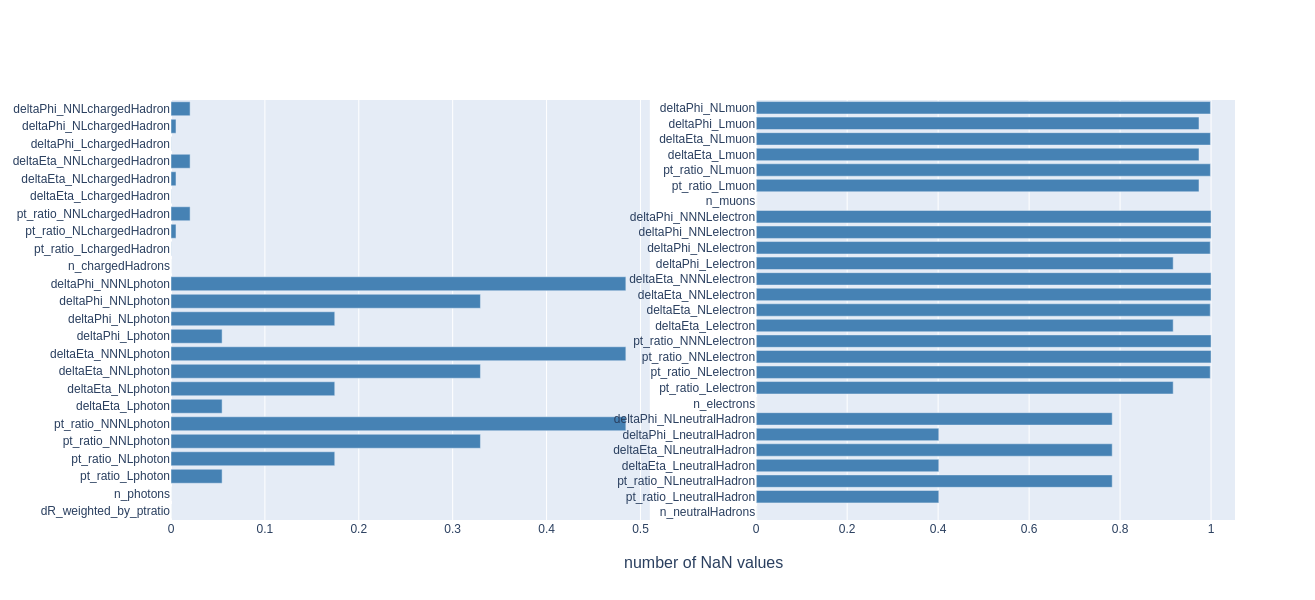

In [8]:
#check data
(lengdata,)=data['dm_gen'].shape
n_minus10=[lengdata-X[bra].mask(X[bra]==-10).count() for bra in bran ]
n_minus10_percent=[x/lengdata for x in n_minus10]
#pd.DataFrame(np.column_stack((bran,n_minus10)))
fig = make_subplots(rows=1, cols=2,x_title='number of NaN values')
fig.add_trace(
go.Bar( x=n_minus10_percent[:24],
            y=bran[:24],
            orientation='h',marker_color='steelblue'),
row=1, col=1
)
fig.add_trace(
go.Bar( x=n_minus10_percent[24:],
            y=bran[24:],
            orientation='h',marker_color='steelblue'),
row=1, col=2
)
fig.update_layout(showlegend=False,autosize=False,width=1000,height=600) 
fig.show()
fig.write_image('n_minus10.svg')
#n_minus10_percent_old=n_minus10_percent;

In [9]:
#n_minus10_percent_diff=[abs(x[0]-x[1]) for x in zip(n_minus10_percent_old,n_minus10_percent)]
#fig = make_subplots(rows=1, cols=2,x_title='less NaN value after changing dR 02->03')
#fig.add_trace(
#go.Bar( x=n_minus10_percent_diff[:19],
#            y=bran[:19],
#          orientation='h',marker_color='steelblue'),
#row=1, col=1)
#fig.add_trace(
#go.Bar( x=n_minus10_percent_diff[19:],
#            y=bran[19:],
#            orientation='h',marker_color='steelblue'),
#row=1, col=2)
#fig.show()
#fig.write_image('n_minus10_diff.svg')

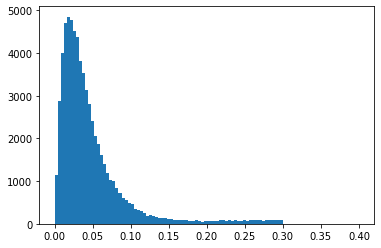

In [10]:
plt.hist(pow(pow(X['deltaPhi_LchargedHadron'],2)+pow(X['deltaEta_LchargedHadron'],2),.5),range=(0,.4),bins=100,log=False);
zzip=zip(X['deltaPhi_LchargedHadron'],X['deltaEta_LchargedHadron'],y)
y_selected=[];
for x1,x2,y1 in zzip:
    if(pow(pow(x1,2)+pow(x2,2),.5)<.004):
        y_selected.append(y1);
#y_selected=[ev['dm_gen'] for ev in data if pow(pow(ev['deltaPhi_LchargedHadron'],2)+pow(ev['deltaEta_LchargedHadron'],2),.5)<0.004]
#plt.hist(y_selected,range=(0,13),bins=13);
#plt.savefig('c1_jet.svg')

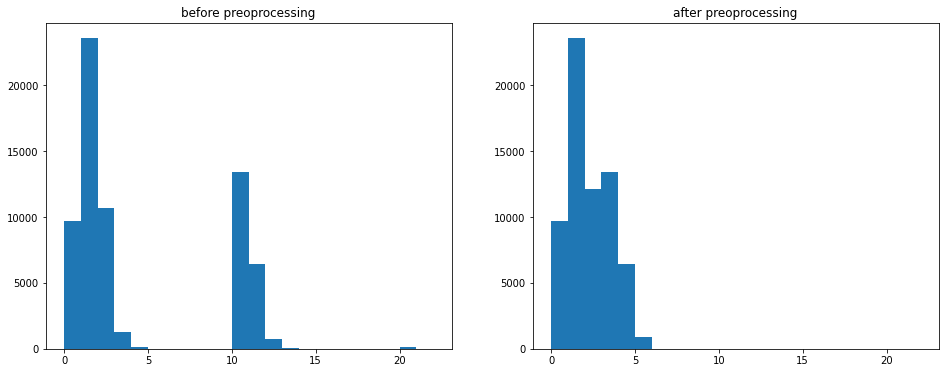

In [11]:
#data preprocessing
y_pre=y.copy()
y_pre=y_pre.replace([3,4,5],2)
y_pre=y_pre.replace([12,13,14,20,21],15)#other category labeled as 15
y_pre=y_pre.replace([10,11,15],[3,4,5])#0:dm0 1:dm1: 2:dm2+3+4+5, 3:dm10 4:dm11 5:other
fig,axs=plt.subplots(1,2,figsize=(16,6))
hist_sizes=axs[0].hist(y,bins=22,range=(0,22));
axs[0].set_title('before preoprocessing');
hist_sizes_pre=axs[1].hist(y_pre,bins=22,range=(0,22));
axs[1].set_title('after preoprocessing');

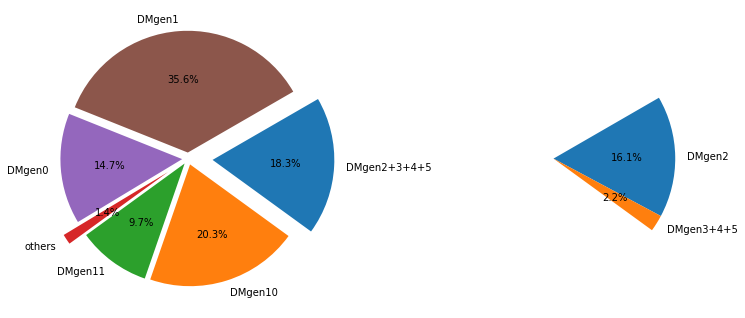

In [12]:
#before/after preprocessing visualization
fig,axs=plt.subplots(1,2,figsize=(12,6))
#plt.pie(
axs[0].pie(hist_sizes_pre[0][[2,3,4,5,0,1]],autopct='%1.1f%%',labels=['DMgen2+3+4+5','DMgen10','DMgen11','others','DMgen0','DMgen1'],
           explode=(.2,0.05,0.05,.2,.05,.05),startangle=30,counterclock=False);
ratios=[hist_sizes[0][2],hist_sizes[0][3:6].sum()]/hist_sizes_pre[0].sum();
axs[1].pie(ratios,normalize=False,autopct='%1.1f%%',labels=['DMgen2','DMgen3+4+5'],
           startangle=30,counterclock=False)
#plt.Axes.set_xticks()
fig.savefig('a3.svg')

# training

In [13]:
# model training | random forest
X_train, X_test, y_train, y_test = train_test_split(X, y_pre, test_size=0.25, random_state=42)
random_forest = RandomForestClassifier(n_estimators=100,criterion='gini',
                                       min_samples_leaf=5,max_depth=15,max_features=None,
                                       n_jobs=-1)
#BDT=GradientBoostingClassifier(n_estimators=100, learning_rate=10.0,
#                           max_depth=5, random_state=0)
random_forest.fit(X_train, y_train);
#BDT.fit(X_train,y_train);
#clf = DecisionTreeClassifier(min_samples_leaf=30).fit(X_train, y_train)
#y_pred=clf.predict(X_train)
#y_train_rfpred=random_forest.predict(X_train)
y_rf_pred=random_forest.predict(X_test)
#y_BDT_pred=BDT.predict(X_test)

In [14]:
#LightGBM
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
param = {'num_leaves': 5, 'objective': 'multiclass','num_class':6,'metric':'multi_logloss','force_row_wise':True}
num_round=1000
bst = lgb.train(param, lgb_train, num_round, valid_sets=[lgb_train,lgb_test],
              callbacks=[lgb.log_evaluation(10),lgb.early_stopping(stopping_rounds=5)])
#num_splits=5
#cv_score=lgb.cv(param, lgb_train, num_round, nfold=num_splits, callbacks=[lgb.log_evaluation(10),lgb.early_stopping(stopping_rounds=5)],
#       return_cvbooster=True)
#y_GBM_split_pred = cv_score['cvbooster'].predict(X_test,num_iteration=np.argmin(cv_score['multi_logloss-mean']))
#y_GBM_pred_class=(sum(y_GBM_split_pred)/num_splits).argmax(axis=1)
y_GBM_pred=bst.predict(X_test,num_iteration=bst.best_iteration).argmax(axis=1)


[LightGBM] [Info] Total Bins 8914
[LightGBM] [Info] Number of data points in the train set: 49653, number of used features: 45
[LightGBM] [Info] Start training from score -1.917458
[LightGBM] [Info] Start training from score -1.032342
[LightGBM] [Info] Start training from score -1.693712
[LightGBM] [Info] Start training from score -1.589656
[LightGBM] [Info] Start training from score -2.351134
[LightGBM] [Info] Start training from score -4.286319
Training until validation scores don't improve for 5 rounds
[10]	training's multi_logloss: 1.04346	valid_1's multi_logloss: 1.05848
[20]	training's multi_logloss: 0.924994	valid_1's multi_logloss: 0.944516
[30]	training's multi_logloss: 0.880382	valid_1's multi_logloss: 0.903598
[40]	training's multi_logloss: 0.857516	valid_1's multi_logloss: 0.883959
[50]	training's multi_logloss: 0.842991	valid_1's multi_logloss: 0.872369
[60]	training's multi_logloss: 0.832797	valid_1's multi_logloss: 0.865021
[70]	training's multi_logloss: 0.824427	valid_1

In [15]:
zipp=np.column_stack((bran,random_forest.feature_importances_))
Feature_unrelated=[row[0] for row in zipp if float(row[1])<1e-6]
Feature_unrelated

['pt_ratio_NNLelectron',
 'pt_ratio_NNNLelectron',
 'deltaEta_NNLelectron',
 'deltaEta_NNNLelectron',
 'deltaPhi_NNLelectron',
 'deltaPhi_NNNLelectron',
 'pt_ratio_NLmuon',
 'deltaEta_NLmuon',
 'deltaPhi_NLmuon']

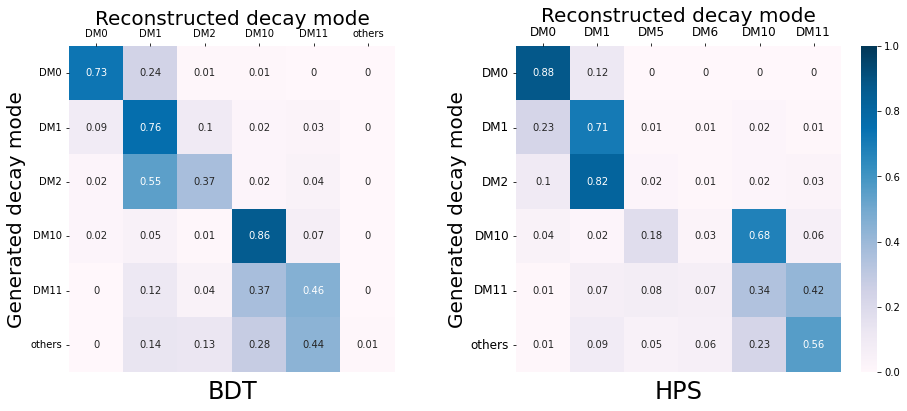

In [16]:
#PuBu = colormap.get_cmap('PuBu', 12)
display_number=[2,3]
cm_rf=confusion_matrix(y_test,y_rf_pred,normalize='true')
cm_BDT=confusion_matrix(y_test,y_GBM_pred,normalize='true')
fig,axs=plt.subplots(1,len(display_number),figsize=(8*len(display_number),6))
if(display_number.count(1)):
    axi=axs[display_number.index(1)]
    sns.heatmap(cm_rf.round(2), ax=axi,linewidth=.0, annot=True,cmap="PuBu",vmin=0, vmax=1,cbar=False,square=True,
                     xticklabels=["DM0","DM1","DM2","DM10","DM11","others"],
                     yticklabels=["gen0","gen1","gen2","gen10","gen11","other"],);
    axi.yaxis.set_ticklabels(["DM0","DM1","DM2","DM10","DM11","others"],rotation=0)
    axi.xaxis.tick_top()
    axi.xaxis.set_label_position('top')
    axi.set_xlabel('Reconstructed decay mode',size=20)
    axi.set_ylabel('Generated decay mode',size=20)
    axi.set_title('random forest',size=24,y=-0.1)

if(display_number.count(2)):
    axi=axs[display_number.index(2)]
    sns.heatmap(cm_BDT.round(2), ax=axi,linewidth=.0, annot=True,cmap="PuBu",vmin=0, vmax=1,cbar=False,square=True,
                     xticklabels=["DM0","DM1","DM2","DM10","DM11","others"],
                     yticklabels=["gen0","gen1","gen2","gen10","gen11","other"],);
    axi.yaxis.set_ticklabels(["DM0","DM1","DM2","DM10","DM11","others"],rotation=0)
    axi.xaxis.tick_top()
    axi.xaxis.set_label_position('top')
    axi.set_xlabel('Reconstructed decay mode',size=20)
    axi.set_ylabel('Generated decay mode',size=20)
    axi.set_title('BDT',size=24,y=-0.1)

#HPSmatrix=pd.crosstab(y_pre,dm_HPS,normalize='index').round(2)
HPSmatrix=np.array([[0.88,0.12,0,0,0,0],
    [0.23,0.71,0.01,0.01,0.02,0.01],
    [0.10,0.82,0.02,0.01,0.02,0.03],
    [0.04,0.02,0.18,0.03,0.68,0.06],
    [0.01,0.07,0.08,0.07,0.34,0.42],
    [0.01,0.09,0.05,0.06,0.23,0.56]])
if(display_number.count(3)):
    axi=axs[display_number.index(3)]
    sns.heatmap(HPSmatrix,ax=axi, linewidth=.0, annot=True,cmap="PuBu",vmin=0, vmax=1,
                 xticklabels=["DM0","DM1","DM5","DM6","DM10","DM11"],
                 yticklabels=["gen0","gen1","gen2","gen10","gen11","others"],)
    plt.xlabel('Reconstructed decay mode',size=20)
    plt.ylabel("Generated decay mode",size=20,rotation=90)
    axi.xaxis.tick_top()
    axi.xaxis.set_label_position('top')
    axi.yaxis.set_ticklabels(["DM0","DM1","DM2","DM10","DM11","others"],rotation=0)
    axi.tick_params(axis='both', which='major', labelsize=12)
    axi.set_title('HPS',size=24,y=-0.1)
fig.show()
plt.savefig(fname="b2_dR02_jet.png")

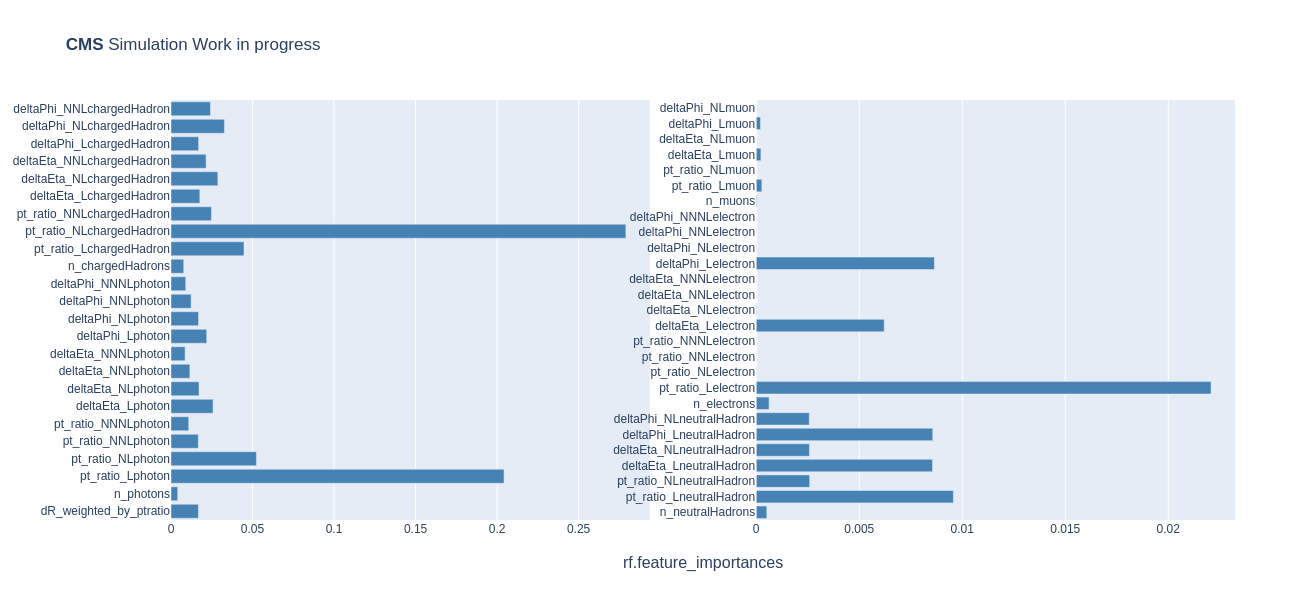

In [42]:
#feature_importances_old=feature_importances
fig = make_subplots(rows=1, cols=2,x_title="rf.feature_importances")
fig.add_trace(
go.Bar( x=random_forest.feature_importances_[:24],
            y=bran[:24],
            orientation='h',marker_color="steelblue"),
row=1, col=1)
fig.add_trace(
go.Bar( x=random_forest.feature_importances_[24:],
            y=bran[24:],
            orientation='h',marker_color="steelblue"),
row=1, col=2)
fig.update_layout(showlegend=False,autosize=False,width=1000,height=600,title_text="<b>CMS</b> Simulation Work in progress")
fig.show()
fig.write_image('feature_importances_.svg')

<AxesSubplot:title={'center':'$\\bf{CMS}$ Simulation Work in progress'}, xlabel='Feature importance', ylabel='Features'>

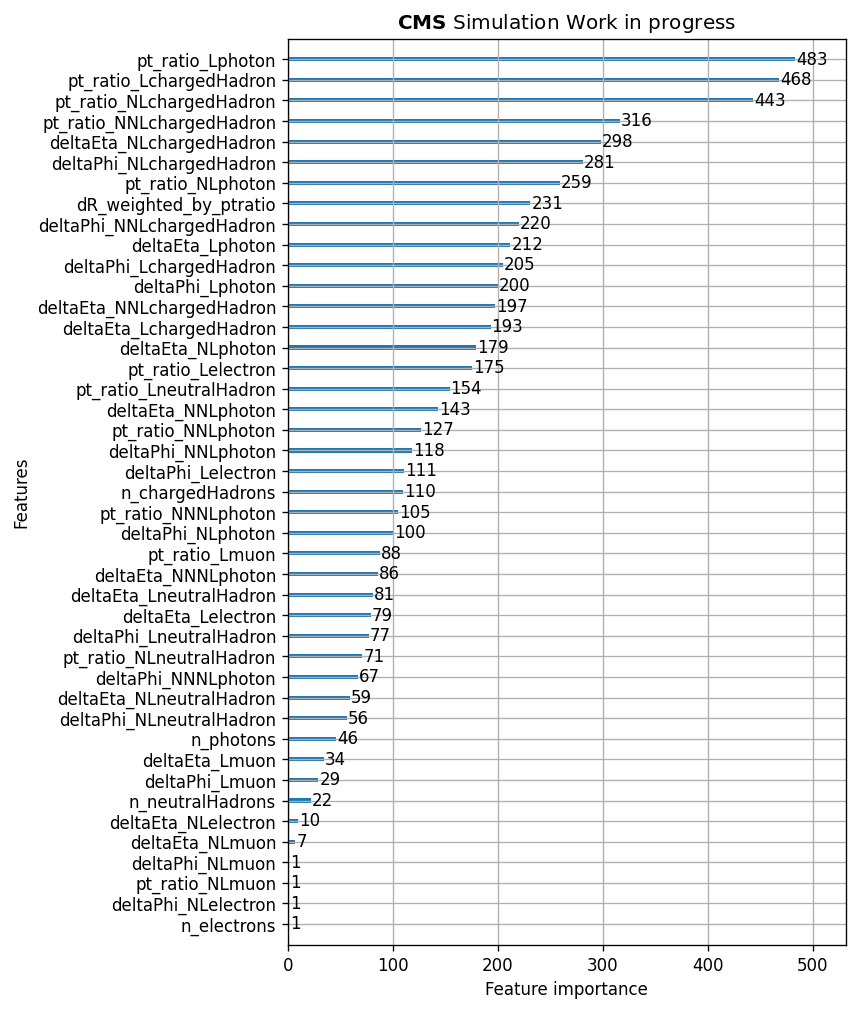

In [27]:

lgb.plot_importance(bst,height=0.2,figsize=(6,10),dpi=120,title=r"$\bf{CMS}$"+' Simulation Work in progress')